In [115]:
path = "/content/drive/MyDrive/Graduate/Semester 1 (Fall 2024)/INFO-H423 Data Mining/Project/SNCB_IncidentClassifier/models/anomaly_detection"

In [116]:
%cd $path
%ls

/content/drive/MyDrive/Graduate/Semester 1 (Fall 2024)/INFO-H423 Data Mining/Project/SNCB_IncidentClassifier/models/anomaly_detection
'1120 - Eval.ipynb'        '1130 - Classification.ipynb'   main.py        Test.ipynb
'1127 - Eval.ipynb'        '1201 - Classification.ipynb'   model.png      utils.py
'1127 - TFIDF.ipynb'        anomaly_detection.py           __pycache__/   visualizations/
'1128 - Comp viz.ipynb'     data/                          README.md
'1128 - Result viz.ipynb'   embeddings/                    results/


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_recall_fscore_support, classification_report

from ast import literal_eval

In [118]:
perc = 10

In [119]:
df = pd.read_csv(f'./data/top_seq_{perc}.csv', index_col=0)
print(df.shape)
df.head()

(4295, 155)


,t00,t01,t02,t03,t04,t05,t06,t07,t08,t09,...,t145,t146,t147,t148,t149,anom_count,incident_id,num,class,mse
21,3986,2744,4002,2852,4110,2854,2982,4148,2708,4026,...,1720,1740,1780,2652,3260,149,4432881,21,ambiguous,57.280702
19,3082,4394,3086,1286,1720,1740,1760,1780,4396,1286,...,2702,4394,1250,2708,2708,129,4432881,19,ambiguous,57.113400
20,2652,4094,2742,4026,4148,2708,3036,4394,4168,4140,...,1760,1780,1286,2652,3260,139,4432881,20,ambiguous,57.028273
44,2956,2956,2956,4066,4066,3636,3658,4078,2956,2956,...,2956,4066,4066,3636,3658,84,4432943,17,ambiguous,12.910184
43,2956,2956,2956,2956,2956,2956,4066,4066,3636,3658,...,2956,2956,2956,2956,4066,81,4432943,16,ambiguous,12.757546


In [120]:
df['incident_id'].unique().shape

(912,)

In [121]:
vocab_path = './embeddings/metadata.tsv'
vectors_path = './embeddings/vectors.tsv'
vocab = pd.read_csv(vocab_path, delimiter='\t', header=None)
vocab.columns = ['word']
vectors = pd.read_csv(vectors_path, delimiter='\t', header=None)
vocab_lookup = dict()
for idx, row in vocab.iterrows():
    vocab_lookup[row['word']] = vectors.iloc[idx].values

In [122]:
def encode_seqs(df, vocab_lookup):
    encoded = []
    for _, row in df.iterrows():
        seq = []
        for i, step in enumerate(row.values):
            try:
                seq.append(vocab_lookup[str(step)])
            except:
                print(f'Unknown: {step}')
                seq.append(vocab_lookup['[UNK]'])
        encoded.append(seq)
    print(len(encoded), len(encoded[0]))
    return np.array(encoded)

In [125]:
df_seq = df.drop(columns=['anom_count', 'incident_id', 'num', 'class', 'mse'], axis=1)
df_encoded = encode_seqs(df_seq, vocab_lookup)
df_encoded.shape

Unknown: 1038
Unknown: 1038
Unknown: 1038
Unknown: 1038
Unknown: 1038
Unknown: 1038
Unknown: 1038
Unknown: 1038
4295 150


(4295, 150, 50)

In [126]:
df_og = pd.read_csv('../../data/time_sorted_table.csv', delimiter=';', index_col=0)
df_og.head(3)

,incident_id,vehicles_sequence,events_sequence,seconds_to_incident_sequence,approx_lat,approx_lon,train_kph_sequence,dj_ac_state_sequence,dj_dc_state_sequence,incident_type
0,4432881,"[609, 609, 609, 609, 609, 609, 609, 609, 609, ...","[2744, 4004, 2852, 4110, 2854, 4396, 1132, 414...","[-5510, -5510, -5507, -5507, -5506, -5506, -55...",50.876601,4.718143,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",4
1,4432943,"[526, 526, 1094, 526, 526, 526, 1094, 1094, 10...","[2744, 4148, 4016, 4394, 1566, 1570, 4394, 156...","[-8573, -8573, -8572, -8032, -8032, -8032, -80...",51.037435,4.431218,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",13
2,4432955,"[592, 592, 592, 643, 643, 643, 616, 616, 616, ...","[4394, 1566, 1570, 4394, 1566, 1570, 2674, 156...","[-12291, -12291, -12291, -12291, -12291, -1229...",50.864083,4.162115,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",14


In [127]:
df_og['incident_id'].unique().shape, df['incident_id'].unique().shape

((1011,), (912,))

In [128]:
incident_type_dict = dict()
for idx, row in df_og.iterrows():
    incident_type_dict[row['incident_id']] = row['incident_type']

df['incident_type'] = df['incident_id'].map(incident_type_dict)
df.head(3)

,t00,t01,t02,t03,t04,t05,t06,t07,t08,t09,...,t146,t147,t148,t149,anom_count,incident_id,num,class,mse,incident_type
21,3986,2744,4002,2852,4110,2854,2982,4148,2708,4026,...,1740,1780,2652,3260,149,4432881,21,ambiguous,57.280702,4
19,3082,4394,3086,1286,1720,1740,1760,1780,4396,1286,...,4394,1250,2708,2708,129,4432881,19,ambiguous,57.113400,4
20,2652,4094,2742,4026,4148,2708,3036,4394,4168,4140,...,1780,1286,2652,3260,139,4432881,20,ambiguous,57.028273,4


In [129]:
df['incident_type'].value_counts()

,count
incident_type,
13,1259
2,775
9,550
14,543
99,522
4,364
11,154
17,45
6,33


In [130]:
df_encoded.shape, df['incident_type'].shape

((4295, 150, 50), (4295,))

In [131]:
y = np.array(df['incident_type'].to_list())

y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

In [132]:
X = df_encoded

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((3006, 150, 50), (1289, 150, 50))

In [133]:
scaler = StandardScaler()

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(X_train.shape)

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

In [134]:
seq_length = X.shape[1]
embedding_dim = X.shape[2]
num_classes = len(np.unique(y))

In [135]:
X_train.max(), X_train.min()

(56.13705, -52.804596)

In [136]:
def build_lstm_model():
    event_input = layers.Input(shape=(seq_length, embedding_dim), name='event_input')
    lstm = layers.LSTM(units=100, dropout=0.3,
                       kernel_initializer='glorot_uniform')(event_input)
    x = layers.Dense(64, activation='relu')(lstm)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.models.Model(inputs=[event_input], outputs=output)
    opt = optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6, clipvalue=1.0)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ event_input (InputLayer)             │ (None, 150, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,644 (264.23 KB)

 Trainable params: 67,644 (264.23 KB)

 Non-trainable params: 0 (0.00 B)

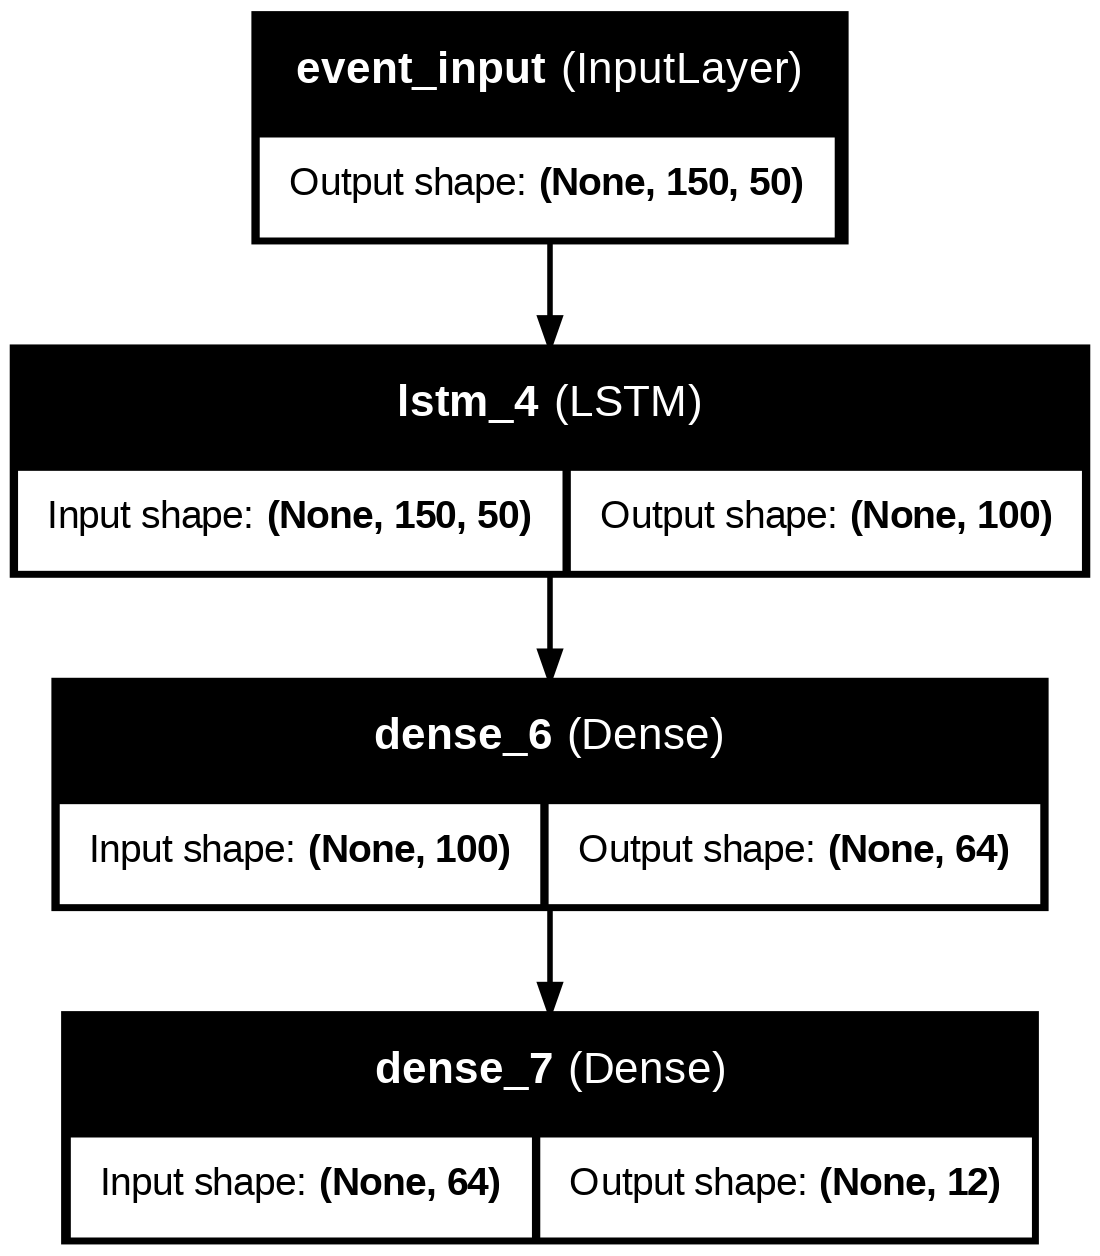

In [137]:
model_lstm = build_lstm_model()
keras.utils.plot_model(model_lstm, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [138]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                          patience=2, verbose=1, factor=0.3, min_lr=0.000001)

callbacks_list = [early, learning_rate_reduction]

In [139]:
history = model_lstm.fit({"event_input": X_train_scaled}, y_train,
                         batch_size=36, verbose=1, epochs=100,
                         validation_split=0.2)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2662 - loss: 2.2478 - val_accuracy: 0.4468 - val_loss: 1.6680
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4974 - loss: 1.5807 - val_accuracy: 0.5116 - val_loss: 1.4978
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5584 - loss: 1.3787 - val_accuracy: 0.4053 - val_loss: 1.6814
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5114 - loss: 1.5016 - val_accuracy: 0.5216 - val_loss: 1.4345
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5753 - loss: 1.3180 - val_accuracy: 0.6694 - val_loss: 1.1658
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6716 - loss: 1.1059 - val_accuracy: 0.5748 - val_loss: 1.3188
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6276 - loss: 1.1663 - val_accuracy: 0.6711 - val_loss: 1.1975
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7016 - loss: 1.0606 - val_accuracy: 0.6811

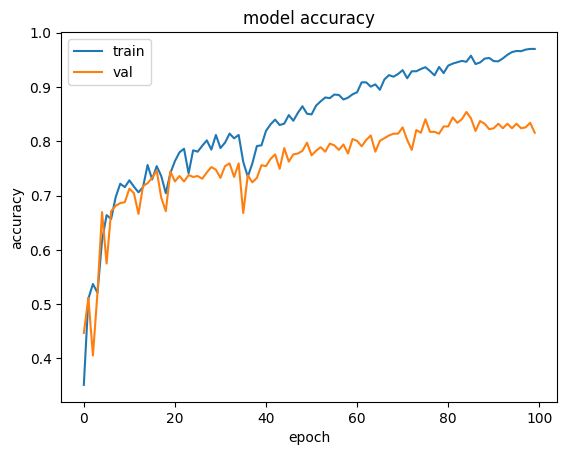

In [140]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [147]:
def get_incident_prediction(df, incident_id):
    df_incident = df[df['incident_id'] == incident_id]
    preds_lst = df_incident['prediction'].to_list()
    return max(set(preds_lst), key=preds_lst.count)

In [142]:
preds = model_lstm.predict(X_test_scaled)
pred_labels = np.argmax(preds, axis=1)
pred_labels.shape

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(1289,)

In [143]:
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       224
           1       0.75      0.33      0.46         9
           2       0.84      0.80      0.82       111
           3       0.62      0.71      0.67         7
           4       0.75      1.00      0.86         6
           5       0.80      0.92      0.86       173
           6       0.70      0.64      0.67        50
           7       0.89      0.87      0.88       378
           8       0.80      0.84      0.82       161
           9       0.00      0.00      0.00         2
          10       0.71      0.62      0.67        16
          11       0.82      0.68      0.75       152

    accuracy                           0.84      1289
   macro avg       0.72      0.70      0.70      1289
weighted avg       0.84      0.84      0.84      1289



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [151]:
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)

preds_full = model_lstm.predict(X_scaled)
pred_labels_full = np.argmax(preds_full, axis=1)
print(classification_report(y_encoded, pred_labels_full))

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       775
           1       0.63      0.71      0.67        24
           2       0.91      0.91      0.91       364
           3       0.84      0.79      0.81        33
           4       0.76      1.00      0.86        19
           5       0.88      0.96      0.92       550
           6       0.84      0.82      0.83       154
           7       0.94      0.93      0.93      1259
           8       0.88      0.92      0.90       543
           9       1.00      0.57      0.73         7
          10       0.83      0.78      0.80        45
          11       0.91      0.77      0.83       522

    accuracy                           0.91      4295
   macro avg       0.86      0.84      0.85      4295
weighted avg       0.91      0.91      0.91      4295



In [152]:
preds_og = y_encoder.inverse_transform(pred_labels_full)
preds_og.shape

(4295,)

In [153]:
df['prediction'] = preds_og
df.head(3)

,t00,t01,t02,t03,t04,t05,t06,t07,t08,t09,...,t147,t148,t149,anom_count,incident_id,num,class,mse,incident_type,prediction
21,3986,2744,4002,2852,4110,2854,2982,4148,2708,4026,...,1780,2652,3260,149,4432881,21,ambiguous,57.280702,4,4
19,3082,4394,3086,1286,1720,1740,1760,1780,4396,1286,...,1250,2708,2708,129,4432881,19,ambiguous,57.113400,4,4
20,2652,4094,2742,4026,4148,2708,3036,4394,4168,4140,...,1286,2652,3260,139,4432881,20,ambiguous,57.028273,4,4


In [154]:
incident_labels = []
incident_preds = []
for incident_id in df['incident_id'].unique():
    incident_labels.append(incident_type_dict[incident_id])
    incident_preds.append(get_incident_prediction(df, incident_id))

len(incident_labels), len(incident_preds)

(912, 912)

In [155]:
print(classification_report(incident_labels, incident_preds))

              precision    recall  f1-score   support

           2       0.93      0.97      0.95       116
           3       0.67      0.80      0.73         5
           4       0.92      0.96      0.94        74
           6       1.00      0.80      0.89         5
           7       0.80      1.00      0.89         4
           9       0.86      0.95      0.90       115
          11       0.85      0.88      0.86        25
          13       0.93      0.93      0.93       290
          14       0.91      0.92      0.92       131
          16       1.00      0.67      0.80         3
          17       0.70      0.78      0.74         9
          99       0.93      0.76      0.83       135

    accuracy                           0.91       912
   macro avg       0.87      0.87      0.86       912
weighted avg       0.91      0.91      0.91       912

